# Comparing recipe's calories using two different data sources.

We have calories data from 2 different columns: nutrition (nutrition data that has been crawled from a website) and derived_nutrition (when not all nutrition data is present in a website, it's is derived/calculated using a machine learning algorithm).

We want to compare the values from both sources to see if they are comparable.

In [1]:
reset -fs

In [2]:
import datalab.bigquery as bq
import itertools
import json
import matplotlib.pyplot as plt
import numpy as np
import operator
import pandas as pd
import pprint
import re
from scipy.stats import wilcoxon, mannwhitneyu
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set_style('white')
%matplotlib inline

To be able to see all content columns of a pandas dataframe, we set the width of the columns to max.

In [3]:
pd.set_option('display.max_colwidth', -1)

To be able to see all numeric data with 2 decimals instead of scientific notation.

In [4]:
pd.options.display.float_format = '{:.2f}'.format

Extracting `derived_nutrition_version`.

In [5]:
%%sql --module derived_nutrition_versions
SELECT
INTEGER(RIGHT(derived_nutrition_version, LENGTH(derived_nutrition_version)-1)) AS nutrition_version
FROM [firebase-wellio:recipes.imported_recipes]
GROUP BY nutrition_version
ORDER BY nutrition_version DESC

In [6]:
%%bigquery execute -q derived_nutrition_versions

nutrition_version
10
9
8
7
6
5
2
""


Latest nutrition version is 10. We will need to specify this version in our BigQuery's to get only the recipes with such attribute and avoid duplicates.

#### Extracting calories from `derived_nutrition` and `nutrition` column. Note that we use URLs from domain `epicurious.com` as they always have `derived_nutrition`.

In [7]:
%%sql --module epicurious_compare_calories_nutrition
SELECT url, derived_nutrition AS derived_calories, nutrition AS calories, 
FLOAT(RIGHT(nutrition, LENGTH(nutrition) - LENGTH('Calories'))) AS calories_amount,
yield
FROM FLATTEN([firebase-wellio:recipes.imported_recipes], nutrition)
WHERE url LIKE '%epicurious.com%' AND derived_nutrition IS NOT NULL AND INTEGER(RIGHT(derived_nutrition_version, 
  LENGTH(derived_nutrition_version)-1)) = 10 AND derived_nutrition LIKE '%"unit": "kcal"%'
AND nutrition LIKE 'Calories%'
  AND nutrition NOT LIKE 'Calories from%'

In [8]:
%%bigquery execute -q epicurious_compare_calories_nutrition

url,derived_calories,calories,calories_amount,yield
http://www.epicurious.com/recipes/member/views/cold-brew-iced-coffee-concentrate-51867001,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 632.2039904173668}",Calories 26,26.0,5 cups concentrate
http://www.epicurious.com/recipes/member/views/quinoa-patties-52707551,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 5229.592186739095}",Calories 176,176.0,24 patties
http://www.epicurious.com/recipes/member/views/puppy-chow-50046333,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 3491.826000616919}",Calories 319,319.0,
http://www.epicurious.com/recipes/member/views/orzo-salad-with-basil-tomatoes-olives-1200649,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 2748.2456049771486}",Calories 169,169.0,6 servings
http://www.epicurious.com/recipes/food/views/green-bean-and-radish-salad-5,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 1204.8781298407957}",Calories 296,296.0,Serves 4
http://www.epicurious.com/recipes/member/views/miso-glazed-salmon-1238886,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 1631.687967470364}",Calories 906,906.0,2 8 ounce portions
http://www.epicurious.com/recipes/member/views/peach-and-avacado-salsa-50101950,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 630.8921274181932}",Calories 138,138.0,
http://www.epicurious.com/recipes/food/views/exotic-caramel-sauce-5163,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 2896.908371192394}",Calories 388,388.0,Makes 2 1/2 cups
http://www.epicurious.com/recipes/member/views/fresh-fruit-salad-with-honey-vanilla-yogurt-1273447,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 1268.4680656093303}",Calories 182,182.0,
http://www.epicurious.com/recipes/member/views/fresh-fruit-bars-52971801,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 2581.4382436328965}",Calories 133,133.0,12


Note that we import a column called `yield`. Since we want to be able to compare calories from both columns, we will need to eventually divide the calory amount from `derived_nutrition` by `yield`.

Export data to pandas dataframe.

In [9]:
epicurious_calories_df = bq.Query(epicurious_compare_calories_nutrition).to_dataframe()

In [10]:
epicurious_calories_df.head()

,url,derived_calories,calories,calories_amount,yield
0,http://www.epicurious.com/recipes/food/views/pasta-with-tomatoes-and-goat-cheese-103833,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 2813.6989705594024}",Calories 605,605.00,Makes 4 to 6 servings
1,http://www.epicurious.com/recipes/food/views/parmesan-roasted-butternut-squash-350608,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 1028.9744300143527}",Calories 168,168.00,Makes 8 servings
2,http://www.epicurious.com/recipes/food/views/crisp-roast-duck-235744,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 1002.6639500997622}",Calories 2521,2521.00,Makes 4 servings
3,http://www.epicurious.com/recipes/food/views/bearnaise-sauce-395049,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 578.1664392632631}",Calories 235,235.00,Makes about 1 cup
4,http://www.epicurious.com/recipes/food/views/poblano-potato-gratin-350596,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 5088.05744129111}",Calories 295,295.00,Makes 8 (side dish) servings


How many rows of data?

In [11]:
epicurious_calories_df.shape[0]

326657

We extract the serving amount from yield. Note that we only extract the first number in case two or more are present, like 'Makes 6-8 servings', we extract 6.

In [12]:
epicurious_calories_df['yield_amount'] = epicurious_calories_df['yield'].str.extract('([0-9]+)', expand=True)

Converting figure to numeric format.

In [13]:
epicurious_calories_df['yield_amount'] = epicurious_calories_df['yield_amount'].apply(pd.to_numeric)

If no yield is present, instead to replace with 0, we default to 4 (**normally**, recipes are for 4  servings).

In [14]:
epicurious_calories_df['yield_amount'].fillna(4, inplace=True)

Also, if a 0 is present, we replace with 4 (to avoid division by 0 later on).

In [15]:
epicurious_calories_df['yield_amount'].replace(0, 4,inplace=True)

In [16]:
epicurious_calories_df.head()

,url,derived_calories,calories,calories_amount,yield,yield_amount
0,http://www.epicurious.com/recipes/food/views/pasta-with-tomatoes-and-goat-cheese-103833,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 2813.6989705594024}",Calories 605,605.00,Makes 4 to 6 servings,4.00
1,http://www.epicurious.com/recipes/food/views/parmesan-roasted-butternut-squash-350608,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 1028.9744300143527}",Calories 168,168.00,Makes 8 servings,8.00
2,http://www.epicurious.com/recipes/food/views/crisp-roast-duck-235744,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 1002.6639500997622}",Calories 2521,2521.00,Makes 4 servings,4.00
3,http://www.epicurious.com/recipes/food/views/bearnaise-sauce-395049,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 578.1664392632631}",Calories 235,235.00,Makes about 1 cup,1.00
4,http://www.epicurious.com/recipes/food/views/poblano-potato-gratin-350596,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 5088.05744129111}",Calories 295,295.00,Makes 8 (side dish) servings,8.00


Let's check the columns data types.

In [17]:
epicurious_calories_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326657 entries, 0 to 326656
Data columns (total 6 columns):
url                 326657 non-null object
derived_calories    326657 non-null object
calories            326657 non-null object
calories_amount     326657 non-null float64
yield               326657 non-null object
yield_amount        326657 non-null float64
dtypes: float64(2), object(4)
memory usage: 15.0+ MB


Extracting numeric value of derived calories using regex.

In [18]:
epicurious_calories_df['derived_calories_amount'] = epicurious_calories_df['derived_calories'].str.extract('"agg_value": ([0-9]+.[0-9]+)', expand=True)

Converting new column into float data type.

In [19]:
epicurious_calories_df['derived_calories_amount'] = epicurious_calories_df['derived_calories_amount'].apply(pd.to_numeric)

We create a new column by dividing 'derived_calories_amount' by 'yield_amount'.

In [20]:
epicurious_calories_df['yield_derived_calories_amount'] = epicurious_calories_df['derived_calories_amount']/epicurious_calories_df['yield_amount']

Creating a column with the difference between both calories amounts.

In [21]:
epicurious_calories_df['difference_calories_amount'] = epicurious_calories_df['yield_derived_calories_amount'] - epicurious_calories_df['calories_amount']

In [22]:
epicurious_calories_df.head()

,url,derived_calories,calories,calories_amount,yield,yield_amount,derived_calories_amount,yield_derived_calories_amount,difference_calories_amount
0,http://www.epicurious.com/recipes/food/views/pasta-with-tomatoes-and-goat-cheese-103833,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 2813.6989705594024}",Calories 605,605.00,Makes 4 to 6 servings,4.00,2813.70,703.42,98.42
1,http://www.epicurious.com/recipes/food/views/parmesan-roasted-butternut-squash-350608,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 1028.9744300143527}",Calories 168,168.00,Makes 8 servings,8.00,1028.97,128.62,-39.38
2,http://www.epicurious.com/recipes/food/views/crisp-roast-duck-235744,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 1002.6639500997622}",Calories 2521,2521.00,Makes 4 servings,4.00,1002.66,250.67,-2270.33
3,http://www.epicurious.com/recipes/food/views/bearnaise-sauce-395049,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 578.1664392632631}",Calories 235,235.00,Makes about 1 cup,1.00,578.17,578.17,343.17
4,http://www.epicurious.com/recipes/food/views/poblano-potato-gratin-350596,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 5088.05744129111}",Calories 295,295.00,Makes 8 (side dish) servings,8.00,5088.06,636.01,341.01


Checking the columns data types again.

In [23]:
epicurious_calories_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326657 entries, 0 to 326656
Data columns (total 9 columns):
url                              326657 non-null object
derived_calories                 326657 non-null object
calories                         326657 non-null object
calories_amount                  326657 non-null float64
yield                            326657 non-null object
yield_amount                     326657 non-null float64
derived_calories_amount          326657 non-null float64
yield_derived_calories_amount    326657 non-null float64
difference_calories_amount       326657 non-null float64
dtypes: float64(5), object(4)
memory usage: 22.4+ MB


Exploring basic statistics of the calories amount from both sources.

In [24]:
epicurious_calories_df.describe()

,calories_amount,yield_amount,derived_calories_amount,yield_derived_calories_amount,difference_calories_amount
count,326657.00,326657.00,326657.00,326657.00,326657.00
mean,1666.61,5.96,3848.20,815.87,-850.73
std,195041.76,6.50,19033.50,4345.81,195093.03
min,0.00,1.00,0.00,0.00,-44659497.27
25%,254.00,4.00,1587.93,328.12,-68.92
50%,382.00,4.00,2615.59,549.77,54.50
75%,688.00,6.00,4106.10,822.56,265.36
max,44659793.00,1995.00,1929522.72,401618.51,401330.51


How many recipes have 0 calories?

In [25]:
epicurious_0_calories_df = epicurious_calories_df[(epicurious_calories_df['derived_calories_amount'] == 0) | epicurious_calories_df['calories_amount'] == 0]

In [26]:
epicurious_0_calories_df.shape[0]

69

If we don't filter out extreme calories values, we won't get a very useful histogram or box plot.

Let's create a dataframe with calories amount greater than 0 and less than 5,000.

In [27]:
epicurious_calories_0_5000_pre_df = epicurious_calories_df[(epicurious_calories_df['calories_amount'] > 0) & (epicurious_calories_df['calories_amount'] < 5000)]

In [28]:
epicurious_calories_0_5000_df = epicurious_calories_0_5000_pre_df[(epicurious_calories_0_5000_pre_df['derived_calories_amount'] > 0) & (epicurious_calories_0_5000_pre_df['derived_calories_amount'] < 5000)]

In [29]:
epicurious_calories_0_5000_df.describe()

,calories_amount,yield_amount,derived_calories_amount,yield_derived_calories_amount,difference_calories_amount
count,271521.00,271521.00,271521.00,271521.00,271521.00
mean,487.96,5.65,2371.05,545.66,57.71
std,392.84,6.30,1203.71,414.61,478.89
min,1.00,1.00,0.98,0.25,-4578.17
25%,240.00,4.00,1453.84,293.15,-79.55
50%,355.00,4.00,2276.22,477.64,36.19
75%,625.00,6.00,3230.34,698.08,197.33
max,4907.00,1995.00,4998.58,4993.46,4709.46


Scatter plot of both sources of calories (the idea is to perform a Bivariate Analysis).

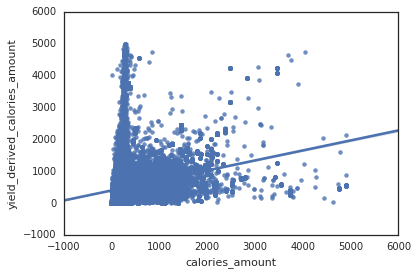

In [30]:
sns.regplot(x=epicurious_calories_0_5000_df['calories_amount'], y=epicurious_calories_0_5000_df['yield_derived_calories_amount'], fit_reg=True);

Let's visualize a distribution of both calories amount using the new created dataframe.

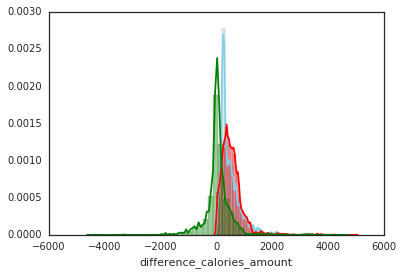

In [31]:
sns.distplot(epicurious_calories_0_5000_df['calories_amount'], color="skyblue", label="Calories from EDAMAM")
sns.distplot(epicurious_calories_0_5000_df['yield_derived_calories_amount'], color="red", label="Derived Calories")
sns.distplot(epicurious_calories_0_5000_df['difference_calories_amount'], color="green", label="Calories Difference");

And a box plot.

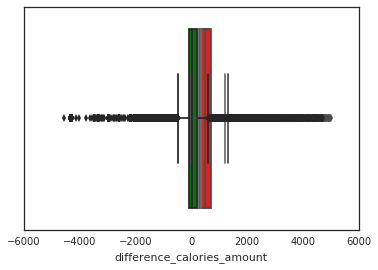

In [32]:
sns.boxplot(x=epicurious_calories_0_5000_df['calories_amount'], color="skyblue");
sns.boxplot(x=epicurious_calories_0_5000_df['yield_derived_calories_amount'], color="red")
sns.boxplot(x=epicurious_calories_0_5000_df['difference_calories_amount'], color="green");

After looking at the scatter plot, let's explore recipes with derived calories > 4000 and calories < 400 which corresponds to the left side of the chart, where seems to be a vertical line (maybe we are estimating high calories for recipes with lower calories).

In [33]:
high_derived_calories_df = epicurious_calories_0_5000_df[(epicurious_calories_0_5000_df['calories_amount'] <= 400) & (epicurious_calories_0_5000_df['yield_derived_calories_amount'] > 4000)]

Let's remove some columns with the raw data.

In [34]:
del high_derived_calories_df['derived_calories']
del high_derived_calories_df['calories']

In [35]:
high_derived_calories_df.head()

,url,calories_amount,yield,yield_amount,derived_calories_amount,yield_derived_calories_amount,difference_calories_amount
227,http://www.epicurious.com/recipes/member/views/banana-bread-1235619,272.00,1 Loaf,1.00,4166.73,4166.73,3894.73
2785,http://www.epicurious.com/recipes/member/views/peach-ice-cream-1234838,276.00,1 quart,1.00,4049.18,4049.18,3773.18
3939,http://www.epicurious.com/recipes/member/views/bourbon-and-barley-pecan-pie-50008356,379.00,1 pie,1.00,4338.07,4338.07,3959.07
4413,http://www.epicurious.com/recipes/member/views/pistachio-ice-cream-1246702,287.00,1.5 Quarts,1.00,4253.24,4253.24,3966.24
5054,http://www.epicurious.com/recipes/member/views/grandma-okeefes-irish-soda-bread-50017726,280.00,1 loaf,1.00,4703.07,4703.07,4423.07


How many rows of data?

In [36]:
high_derived_calories_df.shape[0]

133

Let's get some basic stastics of the 'yield_amount' column as it may be the reason for the big discrepancy between calories and derived calories.

In [37]:
high_derived_calories_df['yield_amount'].describe()

count   133.00
mean    1.00  
std     0.00  
min     1.00  
25%     1.00  
50%     1.00  
75%     1.00  
max     1.00  
Name: yield_amount, dtype: float64

It's seems reasonable to be the issue: all numbers are 1s.

In [38]:
high_derived_calories_df.tail()

,url,calories_amount,yield,yield_amount,derived_calories_amount,yield_derived_calories_amount,difference_calories_amount
324952,http://www.epicurious.com/recipes/member/views/coffee-cake-moms-50044818,288.00,1 loaf,1.00,4807.04,4807.04,4519.04
324953,http://www.epicurious.com/recipes/food/views/pumpkin-bread-367512,258.00,Makes 1 (9-inch) loaf,1.00,4015.73,4015.73,3757.73
325006,http://www.epicurious.com/recipes/member/views/tuna-sauce-for-pasta-50004700,260.00,sauce for 1 lb pasta,1.00,4352.94,4352.94,4092.94
325227,http://www.epicurious.com/recipes/member/views/colorado-pecan-pie-50112652,291.00,1 pie,1.00,4124.75,4124.75,3833.75
326632,http://www.epicurious.com/recipes/food/views/our-favorite-key-lime-pie-56389684,254.00,"1 (9"") pie",1.00,4121.28,4121.28,3867.28


In [39]:
high_derived_calories_df['yield_amount'].replace(1, 4,inplace=True)

We need to recalculate 'yield_derived_calories_amount' as we changed 1s by 4s.

In [40]:
high_derived_calories_df['yield_derived_calories_amount'] = high_derived_calories_df['derived_calories_amount']/high_derived_calories_df['yield_amount']

And again, let's look at a new scatter plot.

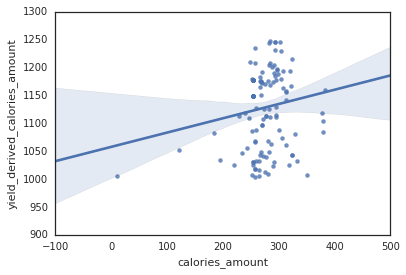

In [41]:
sns.regplot(x=high_derived_calories_df['calories_amount'], y=high_derived_calories_df['yield_derived_calories_amount'], fit_reg=True);

It seems we have an issue with recipes with calories between 250 and 350: the estimates are to high.

Let's create another subset.

In [42]:
subset_high_derived_calories_df = high_derived_calories_df[(high_derived_calories_df['calories_amount'] > 250) & (high_derived_calories_df['calories_amount'] < 350)]

How many rows of data?

In [43]:
subset_high_derived_calories_df.shape[0]

117

Let's look at all rows since there are not too many.

In [44]:
subset_high_derived_calories_df.head(n=117)

,url,calories_amount,yield,yield_amount,derived_calories_amount,yield_derived_calories_amount,difference_calories_amount
227,http://www.epicurious.com/recipes/member/views/banana-bread-1235619,272.00,1 Loaf,4.00,4166.73,1041.68,3894.73
2785,http://www.epicurious.com/recipes/member/views/peach-ice-cream-1234838,276.00,1 quart,4.00,4049.18,1012.29,3773.18
4413,http://www.epicurious.com/recipes/member/views/pistachio-ice-cream-1246702,287.00,1.5 Quarts,4.00,4253.24,1063.31,3966.24
5054,http://www.epicurious.com/recipes/member/views/grandma-okeefes-irish-soda-bread-50017726,280.00,1 loaf,4.00,4703.07,1175.77,4423.07
5805,http://www.epicurious.com/recipes/food/views/our-favorite-key-lime-pie-56389684,254.00,"1 (9"") pie",4.00,4098.15,1024.54,3844.15
5815,http://www.epicurious.com/recipes/food/views/our-favorite-key-lime-pie-56389684,254.00,"1 (9"") pie",4.00,4121.28,1030.32,3867.28
6145,http://www.epicurious.com/recipes/member/views/guiltfree-chocolate-cheesecake-50190015,271.00,1 cheesecake,4.00,4384.35,1096.09,4113.35
6166,http://www.epicurious.com/recipes/member/views/pate-brisee-50142402,277.00,1sngl or 2dbl crust pies,4.00,4454.80,1113.70,4177.80
6170,http://www.epicurious.com/recipes/member/views/guiltfree-chocolate-cheesecake-50190015,271.00,1 cheesecake,4.00,4384.35,1096.09,4113.35
6182,http://www.epicurious.com/recipes/member/views/pate-brisee-50142402,277.00,1sngl or 2dbl crust pies,4.00,4454.80,1113.70,4177.80


The issue is with the yield colum scrapped from the recipe's website or even the calories amount may have been updated on the original recipe's URL, so the data stored in BigQuery reflects a old value.

Also, by looking at the titles/URLs of the recipes (cakes, pies, ice creams...) these items should have high calories from the recipes' website, which in some cases show a calories amount that is for 1 serving.

Now, let's visualize a scatter plot of the other items.

We create another dataframe.

In [45]:
less_derived_calories_df = epicurious_calories_0_5000_df[(epicurious_calories_0_5000_df['calories_amount'] > 400) & (epicurious_calories_0_5000_df['yield_derived_calories_amount'] < 4000)]

Removing unnecesary columns.

In [46]:
del less_derived_calories_df['derived_calories']
del less_derived_calories_df['calories']

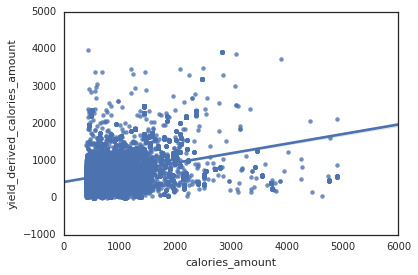

In [47]:
sns.regplot(x=less_derived_calories_df['calories_amount'], y=less_derived_calories_df['yield_derived_calories_amount'], fit_reg=True);

Now seems more correlated.

### Wilcoxon signed-rank test (trying to rank the recipes in terms of their derived calories and the calories from the site, and see if we at least are maintaining the ordering).

Two-sample Wilcoxon test (Mann Whitney U).

In [48]:
statistic, p_value = mannwhitneyu(epicurious_calories_0_5000_df['calories_amount'], epicurious_calories_0_5000_df['yield_derived_calories_amount'])
print "two-sample wilcoxon-test statistic:", statistic
print "two-sample wilcoxon-test p-value:", p_value

two-sample wilcoxon-test statistic: 31704853839.0
two-sample wilcoxon-test p-value: 0.0


In [49]:
statistic, p_value = wilcoxon(epicurious_calories_0_5000_df['calories_amount'] - epicurious_calories_0_5000_df['yield_derived_calories_amount'])
print "paired wilcoxon-test statistic:", statistic
print "paired wilcoxon-test p-value:", p_value

paired wilcoxon-test statistic: 14388406957.0
paired wilcoxon-test p-value: 0.0
